## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers every time
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
prop_converted = len(df.query('converted == 1')) / df.shape[0]
print('The proportion of users converted is {}'.format(prop_converted))

The proportion of users converted is 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
treat_old = len(df.query("group == 'treatment' & landing_page == 'old_page'"))
control_new = len(df.query("group == 'control' & landing_page == 'new_page'"))
print('The number of times the new_page and treatment don"t line up is {}'.format(treat_old + control_new))

The number of times the new_page and treatment don"t line up is 3893


f. Do any of the rows have missing values?

In [7]:
miss_vals = df.isnull().any(axis=1).sum()
print('The number of rows with missing values is {}'.format(miss_vals))

The number of rows with missing values is 0


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

We will now create a new dataframe **df2** that only includes rows in which treatment is aligned with new page and control is aligned with old page.

In [8]:
# We must remove these rows
one_df = df.query("group == 'treatment' & landing_page == 'new_page'")
other_df = df.query("group == 'control' & landing_page == 'old_page'")
df2= one_df.append(other_df)
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [9]:
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(['user_id'], inplace=True)

`4.`

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
prob_conv = len(df2.query('converted == 1')) / len(df2['converted'])
print('The  probability of an individual converting regardless of the page they receive is {}'.format(prob_conv))

The  probability of an individual converting regardless of the page they receive is 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control = df2.query("group == 'control'")
prop_conv_ctrl = len(control.query("converted == '1'")) / control.shape[0]
print('Given that an individual was in the control group, the probability they converted is {}'.format(prop_conv_ctrl))

Given that an individual was in the control group, the probability they converted is 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment = df2.query("group == 'treatment'")
prop_conv_treat = len(treatment.query("converted == '1'")) / treatment.shape[0]
print('Given that an individual was in the treatment group, the probability they converted is {}'.format(prop_conv_treat))

Given that an individual was in the treatment group, the probability they converted is 0.11880806551510564


d. What is the probability that an individual received the new page?

In [18]:
prob_new_page = len(df2.query("landing_page == 'new_page'")) / df2.shape[0]
print('The probability that an individual received the new page is {}'.format(prob_new_page))

The probability that an individual received the new page is 0.5000619442226688


e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Since the sample is so big, I believe there is statistical significance suggesting that one page leads to more conversions. However, I am not sure yet that the difference is big enough to be considered of practical significance.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H_0: p_{new} \le p_{old} $$
$$ H_1: p_{new} > p_{old} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
cr_new_null = len(df2.query('converted == 1')) / len(df2['converted'])
print('The convert rate for P_new under the null is {}'.format(cr_new_null))

The convert rate for P_new under the null is 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
cr_old_null = len(df2.query('converted == 1')) / len(df2['converted'])
print('The convert rate for P_old under the null is {}'.format(cr_old_null))

The convert rate for P_old under the null is 0.11959708724499628


c. What is $n_{new}$?

In [21]:
n_new = len(df2.query("landing_page == 'new_page'"))
print('N_new is {}'.format(n_new))

N_new is 145310


d. What is $n_{old}$?

In [22]:
n_old = len(df2.query("landing_page == 'old_page'"))
print('N_old is {}'.format(n_old))

N_old is 145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1],size=n_new, p=(cr_new_null,1-cr_new_null)) 

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1],size=n_old, p=(cr_old_null,1-cr_old_null))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff_pnew_pold = (new_page_converted.mean()) - (old_page_converted.mean())
print('P_new - P_old for simulated values from e and f is {}'.format(diff_pnew_pold))

P_new - P_old for simulated values from e and f is -0.0015533370500903088


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [26]:
# We could do this simulation two ways: one with a for loop and one using built in numpy functions. I will use the built it
# numpy functions because it is much more efficient computationally.

# Version 1:

#p_diffs = []
#size = df2.shape[0]
#for _ in range(10000):
    #sample = df2.sample(size)
    #new_page_converted = np.random.choice([0,1],size=n_new, p=(cr_new_null,1-cr_new_null))
    #old_page_converted = np.random.choice([0,1],size=n_old, p=(cr_old_null,1-cr_old_null))
    #diff = new_page_converted.mean() - old_page_converted.mean()
    #p_diffs.append(diff)
    
# Version 2:
new_converted_simulation = np.random.binomial(n_new, new_page_converted.mean(), 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, old_page_converted.mean(), 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.

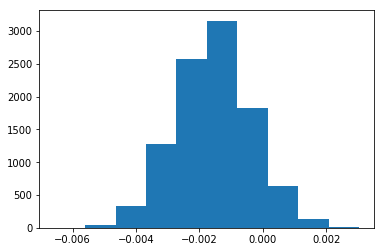

In [27]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# the actual difference observed in ab_data.csv
cr_new_data = len(df2.query('landing_page == "new_page" & converted == 1')) / n_new
cr_old_data = len(df2.query('landing_page == "old_page" & converted == 1')) / n_old
actual_diff = cr_new_data - cr_old_data
print('The actual difference observed in ab_data.csv was: {}'.format(actual_diff))

The actual difference observed in ab_data.csv was: -0.0015782389853555567


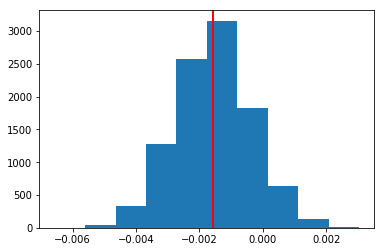

In [29]:
# plot of the proportion of p_diffs greater than the actual difference observed
plt.hist(p_diffs)
plt.axvline(x=actual_diff, color='r', linewidth=2);

In [30]:
p_diffs = np.array(p_diffs)
prop_pdiffs_greater = ((p_diffs > actual_diff).sum()) / len(p_diffs)
print('The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv is {}'.format(prop_pdiffs_greater))

The proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv is 0.5128


**We just computed the P-value. Since it is a high p-val (0.5128), and much greater than the type I error rate of 0.05, then this suggests that we fail to reject the null. This means that there is no statistically significant difference between the conversion rate of the old and new pages or that the new page conversion rate is actually worse than the old page conversion rate. **

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
(z_score, p_value)

(-1.3109241984234394, 0.9050583127590245)

In [33]:
from scipy.stats import norm

norm.cdf(z_score)
# This tells us how significant our z-score is

0.09494168724097551

In [34]:
norm.ppf(1-(0.05/2))
# This tells us what our critical value at 95% confidence is

1.959963984540054

**Since the z-score of -1.311 does not exceed the critical value of 1.959963984540054, we fail to reject the null hypothesis that the difference between the two proportions is no different from zero. These findings agree with the findings in parts j and k that there is no statistically significant difference between the conversion rate of the old and new pages or that the new page conversion rate is actually worse than the old page conversion rate.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['new_page', 'old_page']] = pd.get_dummies(df['landing_page'])

# We could also do it like below, but i like to create columns rather than join them
# to an existing dataframe
#df2= df2.join(pd.get_dummies(df2['landing_page']))

df2['ab_page'] = pd.get_dummies(df['group']) ['treatment']
# again could do it like below, but the line above is a little cleaner
#df['ab_page'] = np.where(df['group']=='treatment', '1', '0')

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1


c. Use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:10:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value associated with ab_page is 0.190. It differs from the value found in Part II because:
In part II our null hypothesis was that the new page conversion rate was less than or equal to our old page conversion rate. And our alternative hypothesis was that P_new was strictly greater than P_old. Therefore, in part II:
$$ H_0 : P_{new} \leq P_{old} $$
$$ H_1 : P_{new} > P_{old} $$
In parts c-e, our null hypothesis is that the new page conversion rate is equal to the old page conversion rate. And our alternative hypothesis is that the new page conversion rate does not equal the old page conversion rate. So in parts c-e:
$$H_0 : P_{new} = P_{old}$$
$$ H_1 : P_{new} \neq P_{old} $$**

f. Now, let's consider other things that might influence whether or not an individual converts. Why is it a good idea to consider other factors to add into our regression model. Are there any disadvantages to adding additional terms into our regression model?

**It would be a good idea to consider other factors to add into your regression model in order to make it fit the data more accurately. For example, you could add a time variable which split the time stamps into "Morning", "Afternoon", "Evening" or days: "Mon", "Tue", etc., in order to see if the time or the day when users access the site is at all correlated with their rate of conversion. 
The disadvantage with adding additional terms is that you have to check that they are not correlated with other explanatory variables because then you would have to add higher order terms and/or interactions into your equation. Which in turn makes the interpretation of the results (and specifically the coefficients) more complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: We will need two columns for the three dummy varaibles.**

In [38]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
df3 = df2.merge(df_countries, on='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1,CA


In [40]:
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop(df3['CA']) #or could also drop doing df3 = df3.drop('CA', axis=1)

In [41]:
# Here we will create our regression model with Canada and Old_page as our baselines
new_log_mod = sm.Logit(df3['converted'], df3[['intercept', 'new_page', 'UK', 'US']])
new_results = new_log_mod.fit()
new_results.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Sep 2018   Pseudo R-squ.:               2.322e-05
Time:                        13:11:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1763
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.306      0.192      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.129      -0.012       0.093
==============================================================================
"""

In [42]:
1/np.exp(-0.0149)

1.0150115583846535

In [43]:
np.exp(0.0506)

1.0519020483004984

In [44]:
np.exp(0.0408)

1.0416437559600236

### Interpretations:
1) For every one unit decrease in new_page, a conversion is 1.5% more likely to happen, holding all other variables constant.

2) An individual is 5.2% more likely to convert if they live in the UK than if they live in Canada, holding all else constant.

3) An individual is 4.2% more likely to convert if they like in the US than if they live in Canda, holding all else constant.

h. We would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [45]:
# First we will create the interaction term between page and country
df3['US_new_page'] = df3['new_page']*df3['US']
df3['UK_new_page'] = df3['new_page']*df3['UK']

In [46]:
final_log_mod = sm.Logit(df3['converted'], df3[['intercept', 'new_page', 'UK_new_page', 'US_new_page', 'UK', 'US']])
final_results = final_log_mod.fit()
final_results.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290582
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            5
Date:                Sun, 30 Sep 2018   Pseudo R-squ.:               3.479e-05
Time:                        13:12:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1923
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.058       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [47]:
np.exp(final_results.params)

intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.048024
UK             1.011854
US             1.017682
dtype: float64

### Interpretations:
1) The p-values in the output above tell us that the interaction effects (UK_new_page and US_new_page) are not statistically significant. Consequently, we know that conversion rate does not depend on which country the users live in.

2) Also, only the intercept has a p-value less than 0.05 so all other variables in the model are statistically insignificant.

3) For every 1 unit decrease in new_page, there is a 7% higher chance of conversion, holding all other variables constant.

4) An individual is 8.1% more likely to convert if they live in the UK and are new_page users than if they live in Canada and are new_page users.

5) An individual is 4.8% more likely to convert if they live in the US and are new_page users than if they live in Canada and are new_page users.

6) An individual is 1.2% more likely to convert if they live in the UK than if they live in Canada.

7) An individual is 1.8% more likely to convert if they live in the US than if they live in Canada.

#### We will now do some model fit tests, to see which of the models fit the data the best

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [49]:
y = df3['converted']
X = df3[['intercept', 'new_page', 'UK_new_page', 'US_new_page', 'UK', 'US']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

In [50]:
# Computed confusion matrix for last regression we did (with the interactions)
model_lm = LogisticRegression()
model_lm.fit(X_train, y_train)
y_preds = model_lm.predict(X_test)
confusion_matrix(y_test, y_preds)

array([[25509,     0],
       [ 3550,     0]], dtype=int64)

In [51]:
y2 = df3['converted']
X2 = df3[['intercept', 'new_page', 'UK', 'US']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=0)

In [52]:
# Computed confusion matrix for 2nd regression we did (without the interactions)
model_lm2 = LogisticRegression()
model_lm2.fit(X2_train, y2_train)
y2_preds = model_lm2.predict(X2_test)
confusion_matrix(y2_test, y2_preds)

array([[51045,     0],
       [ 7072,     0]], dtype=int64)

In [53]:
y3 = df3['converted']
X3 = df3[['intercept', 'ab_page']]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=0)

In [54]:
# Computed confusion matrix for first regression we did (with only ab_page as a predictor variable)
model_lm3 = LogisticRegression()
model_lm3.fit(X3_train, y3_train)
y3_preds = model_lm3.predict(X3_test)
confusion_matrix(y3_test, y3_preds)

array([[51045,     0],
       [ 7072,     0]], dtype=int64)

As can be seen in all three confusion matrices above: most of the true-negative predictions are correct however there are no true-positive predictions and many false-negative predictions. From this we can conclude that none of these models fit the data well.

In [37]:
# We will now create an html version of this report 
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0